**Setting up the project**

In [2]:
# Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
#Import the data
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [4]:
test_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

- one extra column in the train data - the house price
- interestingly, the number of rows between the train and test data look very similar 

Combine the train and test data:

In [5]:
def combine_train_and_test_data(train_data, test_data):
    # Test
    test_data['SalePrice'] = 'unknown'
    test_data['data_set'] = 'test'
    
    #Train
    train_data['data_set'] = 'train'
    train_columns = train_data.columns
    test_data = test_data[train_columns]
    
    #Combine
    combined = pd.concat([test_data, train_data], axis=0)
    
    return combined

In [6]:
df_combined = combine_train_and_test_data(train_data, test_data)
df_combined.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_set
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,unknown,test
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,unknown,test
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,unknown,test


In [7]:
df_combined.shape

(2919, 82)

Check 

The dataset is too big to visualise, there are too many columns to begin visualising the data

In [8]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallCond  

I am breaking the number of columns down into sections of 10 and looking at these

In [9]:
df_combined.iloc[:, :10].isnull().sum()

Id                0
MSSubClass        0
MSZoning          4
LotFrontage     486
LotArea           0
Street            0
Alley          2721
LotShape          0
LandContour       0
Utilities         2
dtype: int64

Going to look at the unique values in each column and decide on the datatype of each column \
This will help me to decide how to process each feature in the pipeline later\
And give me an idea of how to deal with the NA's in the data

In [10]:
def print_unique_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"{column} {unique_values}")

# Plan
- I want to categorise the data based on type
- then replace ordinal values with a number to represent their values, if I can find them
- then process the data based on the data type
- visualise the data
- test various models
- deploy the model based on performance 

**Categorising data into key data types**

In [11]:
# Second attempt at categorising all attributes

id_col = ['Id']
target_col = ['SalePrice']

nominal_cols = ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
                   'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                   'Exterior2nd','MasVnrType','Foundation','BsmtFinType1','BsmtFinType2','Heating','Electrical','Functional',
                   'GarageType','GarageFinish','SaleType','SaleCondition']


ordinal_cols = ['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','HeatingQC',
                   'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','KitchenQual',
                   'TotRmsAbvGrd','Fireplaces','FireplaceQu','GarageCars','GarageQual','GarageCond']

binary_cols = ['CentralAir','PavedDrive']


continuous_cols = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                   'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF',
                   'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']



# Data Cleaning 

The below functions removes NA's with specific values, or mode, median based on the data type

In [12]:
def conducting_data_cleansing(df):
    
    # Step 1.
    # Replace NA's with values from a dictionary - for the Ordinal columns
    rep_val_cols = ['ExterQual','ExterCond','HeatingQC','BsmtQual','BsmtCond','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']      
    condition_dictionary = {
                            'Ex':1,
                            'Gd':2,
                            'TA':3,
                            'Fa':4,
                            'Po':5,
                            np.nan:0        }
    
    def quality_resolving(df, columns):
        for column in columns:
            df[column] = df[column].replace(condition_dictionary) 
    
        return df


    df1 = quality_resolving(df, rep_val_cols)
    
    
    # Map other ordinal columns    
    df1['BsmtExposure'] = df1['BsmtExposure'].map({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0})
    df1['BsmtFinType1'] = df1['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0})
    df1['BsmtFinType2'] = df1['BsmtFinType2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0})
    df1['Functional'] = df1['Functional'].map({'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1})
    df1['GarageFinish'] = df1['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1, np.nan: 0})
    df1['Fence'] = df1['Fence'].map({'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, np.nan: 0})
    
    

    # Step 2. 
    # Replace NA's with specific values - due to logic
    default_cols = ['MasVnrType']
    
    def default_to_none(df,columns):
        for column in columns:
            df[column] = df[column].fillna('none') 

        return df

    df2 = default_to_none(df1, default_cols)
    

    
    
    # Step 3.
    # Replace NA's with mode values - because these are categorical variables
    # Remove and nominal or orindal cols already fixed above
    mode_cols = nominal_cols + ordinal_cols + binary_cols
   
    grouping_cols = ['Neighborhood']


    def find_mode(df, na_cols, grouping_cols):
        for column in na_cols:
            # Group by the specified grouping columns and calculate the mode for each group
            mode_values = df.groupby(grouping_cols)[column].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
            # Fill missing values in the original DataFrame with the mode values
            df[column].fillna(mode_values, inplace=True)

        return df

    df3 = find_mode(df2, mode_cols, grouping_cols)

    
    # Step 4.
    # Replace NA's with mean values - because these are continuous variables
    mean_cols = continuous_cols
   
    
    grouping_cols = ['Neighborhood']


    def find_mean(df, na_cols, grouping_cols):
        for column in na_cols:
            # Group by the specified grouping columns and calculate the mode for each group
            mean_values = df.groupby(grouping_cols)[column].transform(lambda x: x.mean(skipna=True))
            # Fill missing values in the original DataFrame with the mode values
            df[column].fillna(mean_values, inplace=True)
        
        return df

    df4 = find_mean(df3, mean_cols, grouping_cols)
    
    # Step 5.
    # Drop columns - these have so much missing data, it does not seem worth keeping them 
    
    drop_cols = ['PoolQC', 'Fence', 'MiscFeature', 'Alley' ]

    def remove_cols(df, drop_cols):
        df = df.drop(drop_cols, axis=1)

        return df

    df5 = remove_cols(df4,drop_cols)    

    
    
    # Step 6.
    # Map the boolean columns as numbers
    binary_cols_copy = binary_cols
    binary_dict = {
                            'Y':1,
                            'P':1,
                            'N':0
                                    }
    
    def binary_imputing(df, columns):
        for column in columns:
            df[column] = df[column].replace(binary_dict) 
    
        return df


    df6 = binary_imputing(df5, binary_cols_copy)

    
    
    return df6


Check the number of NA's in each column, this should now be 0

In [14]:
pd.options.display.max_rows = 4000
df_cleaned = conducting_data_cleansing(df_combined)
df_cleaned.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

# Visualising Data

In [15]:
# Just doing this for training data, as we cannot visualise the unknown SalesPrices of the test data
train_df = df_cleaned[df_cleaned['data_set']== 'train']

In [16]:
pd.options.display.max_rows = 4000
check = pd.DataFrame(train_df.columns)
#print(check)

In [17]:
train_df = df_cleaned[df_cleaned['data_set']=='train']
train_df['SalePrice'] = train_df['SalePrice'].astype(float)

/tmp/ipykernel_32/2637780888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['SalePrice'] = train_df['SalePrice'].astype(float)


**SalePrice**

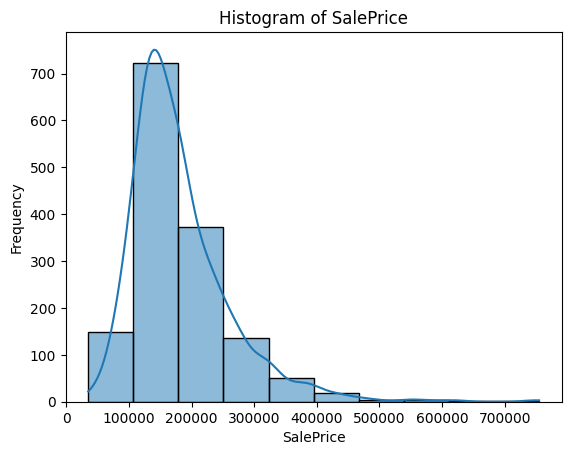

In [18]:
# Create a histogram using seaborn
sns.histplot(train_df['SalePrice'], bins=10, kde=True)  
plt.xlabel('SalePrice')  
plt.ylabel('Frequency')     
plt.title('Histogram of SalePrice')  
plt.show()

/tmp/ipykernel_32/141932302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['log_SalePrice'] = np.log10(train_df['SalePrice'].astype(int))


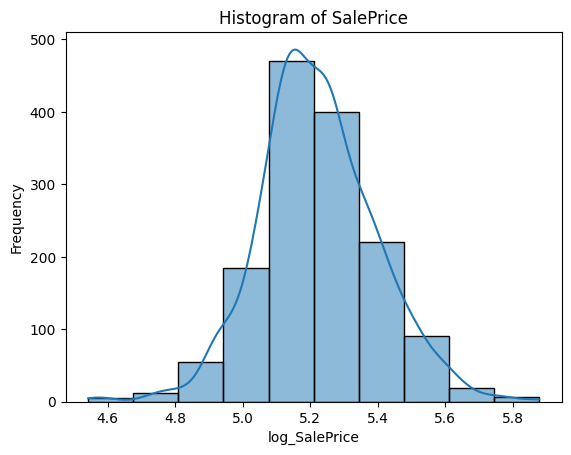

In [19]:
# Lets take the log of the skewed attribute
train_df['log_SalePrice'] = np.log10(train_df['SalePrice'].astype(int))

# Create a histogram using seaborn
sns.histplot(train_df['log_SalePrice'], bins=10, kde=True)  
plt.ylabel('Frequency')     
plt.title('Histogram of SalePrice')  
plt.show()

The dependant variable is highly skewed, taking the logarithm of this has resulted in a more normal distribution of this attribute

**LotFrontage**

0.3480563182471465


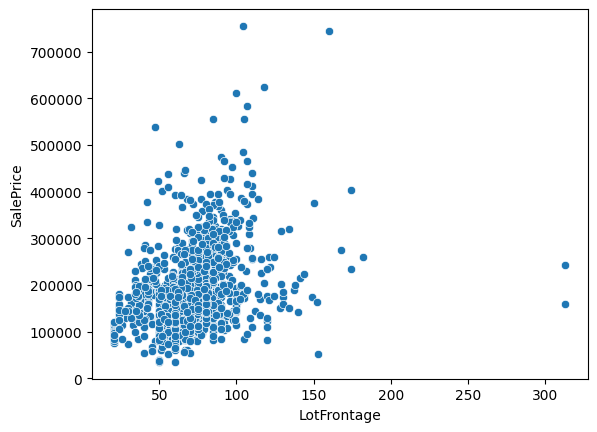

In [20]:
sns.scatterplot(x = "LotFrontage", y = "SalePrice", data =train_df)
print(train_df['LotFrontage'].corr(train_df['SalePrice']))

In [21]:
train_df['LotFrontage'].corr(train_df['SalePrice'])

0.3480563182471465

0.375765444100686


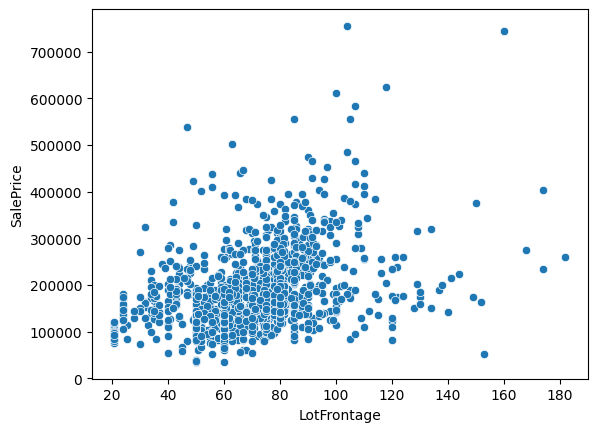

In [22]:
sns.scatterplot(x = "LotFrontage", y = "SalePrice", data =train_df[(train_df['LotFrontage'] < 200)])
print(train_df['LotFrontage'][(train_df['LotFrontage'] < 200)].corr(train_df['SalePrice'][(train_df['LotFrontage'] < 200)]))

<Axes: xlabel='LotFrontage', ylabel='Count'>

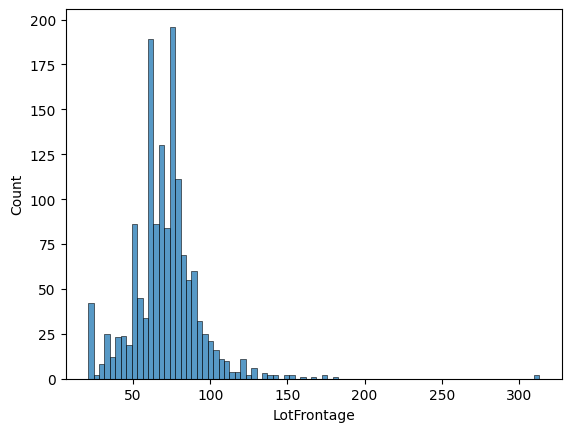

In [23]:
sns.histplot(train_df['LotFrontage'])

Most people don't have a massive LotFrontage, which is why this isn't highly correlated with the SalePrice

**LotArea**

0.3480563182471465


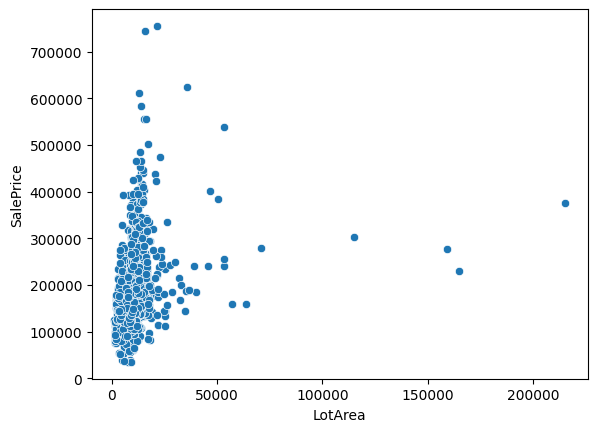

In [24]:
sns.scatterplot(x = "LotArea", y = "SalePrice", data =train_df)
print(train_df['LotFrontage'].corr(train_df['SalePrice']))

<Axes: xlabel='LotArea', ylabel='Count'>

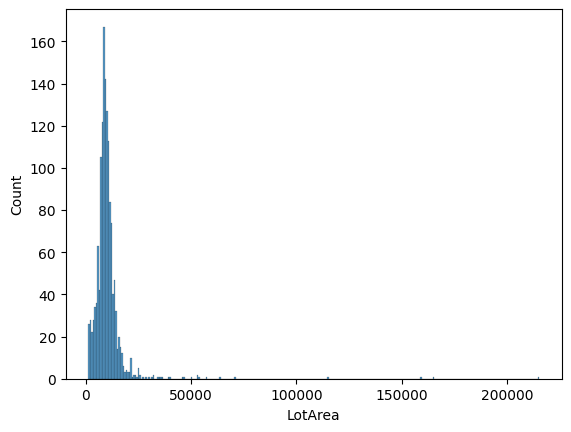

In [25]:
sns.histplot(train_df['LotArea'])

0.38469789953869993


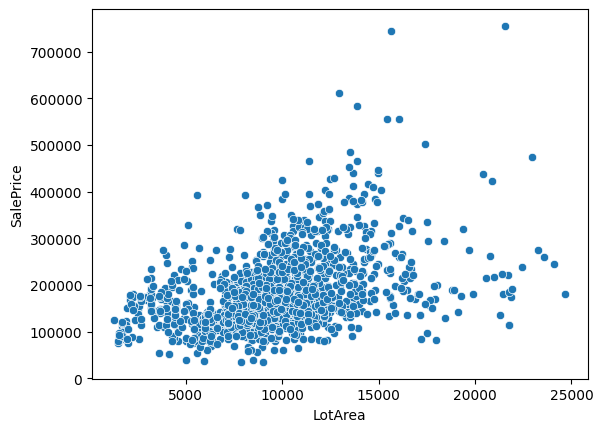

In [26]:
sns.scatterplot(x = "LotArea", y = "SalePrice", data =train_df[train_df['LotArea']<25000])
print(train_df['LotFrontage'][train_df['LotArea']<25000].corr(train_df['SalePrice'][train_df['LotArea']<25000]))

/tmp/ipykernel_32/812052019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['LotArea_log'] = np.log10(train_df['LotArea'].astype(int))


<Axes: xlabel='LotArea_log', ylabel='Count'>

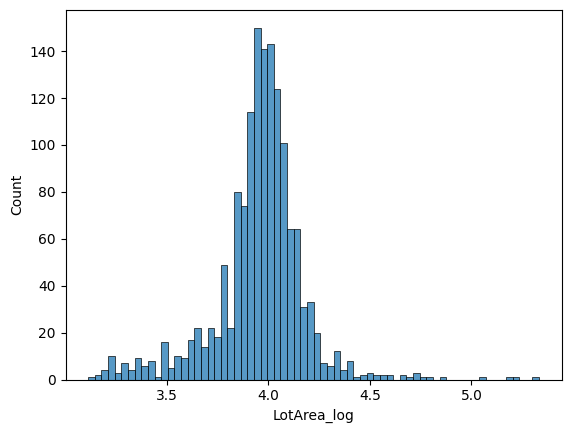

In [27]:
train_df['LotArea_log'] = np.log10(train_df['LotArea'].astype(int))
sns.histplot(train_df['LotArea_log'])

**MSSubClass**

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64


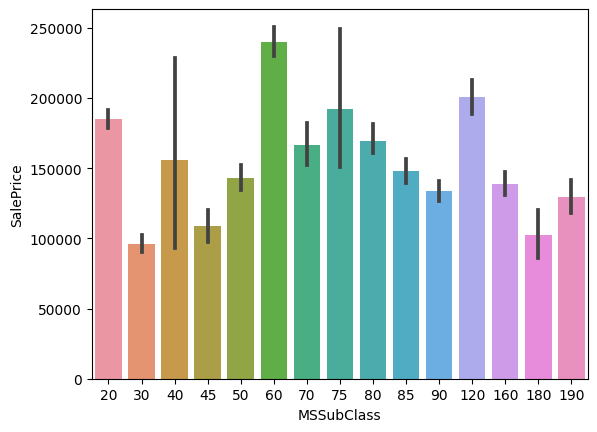

In [28]:
print(train_df['MSSubClass'].value_counts())
sns.barplot(x = "MSSubClass", y="SalePrice", data = train_df);

There seems to be some relation between MSSubClass and the SalePrice

**HouseStyle**

HouseStyle
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: count, dtype: int64


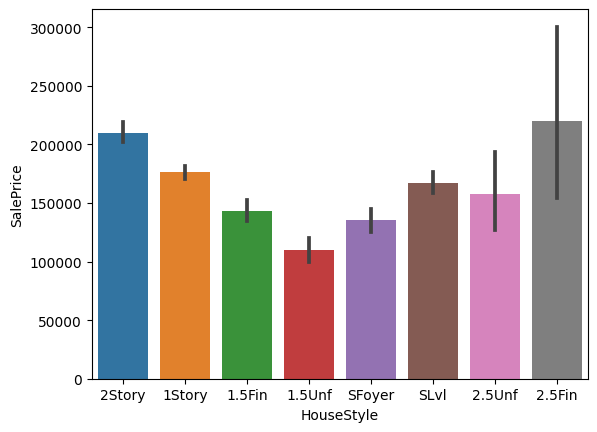

In [29]:
print(train_df['HouseStyle'].value_counts())
sns.barplot(x = "HouseStyle", y="SalePrice", data = train_df);

**YearBuilt**

0.5228973328794969


<Axes: xlabel='YearBuilt', ylabel='SalePrice'>

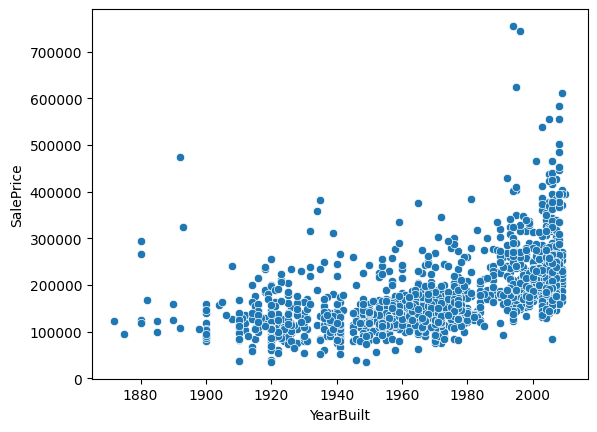

In [30]:
print(train_df['YearBuilt'].corr(train_df['SalePrice']))

sns.scatterplot(x = "YearBuilt", y="SalePrice", data = train_df)



Interesting corelation between SalePrice and YearBuilt

**Street**

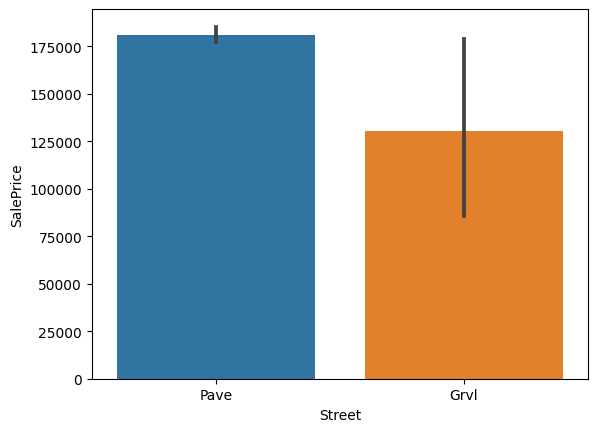

In [31]:
sns.barplot(x = "Street", y="SalePrice", data =train_df);

Grvl has a lower mean but much more variance in the SalePrice

**LotShape**

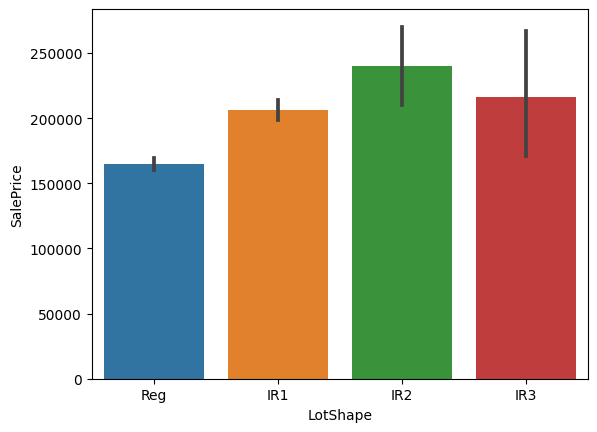

In [32]:
sns.barplot(x = "LotShape", y="SalePrice", data =train_df);

Reg has the lowest mean SalePrice

**For the sake of time, I will not visualise every attribute, though this is a worthwile task, should you have enough time**

# Feature Generation

I would normally generate features, there are however so many in this dataset, that at least for now this is not necessary

# Preparing Data For Modelling

In [170]:
from sklearn.preprocessing import minmax_scale, StandardScaler

def dummy_encoding(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
    dummies = dummies.astype(int)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(feature, axis=1)
    return df


def prepare_features(df, features):
    """Make the feature usable by an ML algorithm"""
    df = df.copy()
    
    for col in df.columns:
        if col not in features['nominal'] + features['ordinal'] \
            + features['boolean'] + features['continuous'] + ['Id','data_set', 'SalePrice']:
            df = df.drop(col, axis=1)
    
    # The model was performing much better when I did not take the log, so I have removed this from the code
    # Convert Lot area to log     
    #df['LotArea'] = np.log10(df['LotArea'])
    
    # Do the same for house price
    #train_df = df[df['data_set'] == 'train']
    #train_df['SalePrice'] = np.log(train_df['SalePrice'].astype(int))
    
    #test_df = df[df['data_set'] == 'test']
    
    #df = pd.concat([train_df, test_df], axis = 0)
            

    # Transform useful features
    for feature in features['nominal']:
        df[feature] = df[feature].astype('category')
        df = dummy_encoding(df, feature)
    
    for feature in features['ordinal'] + features['boolean']:
        df[feature] = df[feature].astype('int')
    
    for feature in features['ordinal'] + features['continuous']:
        scaler = StandardScaler()
        df[[feature]] = scaler.fit_transform(df[[feature]])
        df[feature + '_scaled'] = df[feature]
        df = df.drop(feature, axis=1)
        
    
    return df


# Define type of each feature
features = {
    'nominal': ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
                'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
                'Exterior2nd','MasVnrType','Foundation','BsmtFinType1','BsmtFinType2','Heating','Electrical','Functional',
                'GarageType','GarageFinish','SaleType','SaleCondition'], 
    
    
    
    #,
    #               
 
    
    'ordinal': ['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','HeatingQC',
                   'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','KitchenQual',
                   'TotRmsAbvGrd','Fireplaces','FireplaceQu','GarageCars','GarageQual','GarageCond'],
    
    'boolean': ['CentralAir','PavedDrive'],
    
    'continuous': ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                   'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF',
                   'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']
            }





combined_prepared = prepare_features(df_cleaned, features)
combined_prepared.head()

,Id,CentralAir,PavedDrive,SalePrice,data_set,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,...,GarageArea_scaled,WoodDeckSF_scaled,OpenPorchSF_scaled,EnclosedPorch_scaled,3SsnPorch_scaled,ScreenPorch_scaled,PoolArea_scaled,MiscVal_scaled,MoSold_scaled,YrSold_scaled
0,1461,1,1,unknown,test,0,0,0,0,0,...,1.194293,0.365916,-0.702843,-0.359601,-0.103331,1.850256,-0.06315,-0.089592,-0.078505,1.67886
1,1462,1,1,unknown,test,0,0,0,0,0,...,-0.746775,2.365838,-0.170014,-0.359601,-0.103331,-0.285935,-0.06315,21.944410,-0.078505,1.67886
2,1463,1,1,unknown,test,0,0,0,0,1,...,0.042655,0.935064,-0.199616,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-1.183764,1.67886
3,1464,1,1,unknown,test,0,0,0,0,1,...,-0.013070,2.104979,-0.170014,-0.359601,-0.103331,-0.285935,-0.06315,-0.089592,-0.078505,1.67886
4,1465,1,1,unknown,test,0,0,0,0,0,...,0.154103,-0.740760,0.510823,-0.359601,-0.103331,2.277494,-0.06315,-0.089592,-1.920603,1.67886


In [75]:
combined_prepared.dtypes

Id                         int64
CentralAir                 int64
PavedDrive                 int64
SalePrice                 object
data_set                  object
MSSubClass_30              int64
MSSubClass_40              int64
MSSubClass_45              int64
MSSubClass_50              int64
MSSubClass_60              int64
MSSubClass_70              int64
MSSubClass_75              int64
MSSubClass_80              int64
MSSubClass_85              int64
MSSubClass_90              int64
MSSubClass_120             int64
MSSubClass_150             int64
MSSubClass_160             int64
MSSubClass_180             int64
MSSubClass_190             int64
MSZoning_FV                int64
MSZoning_RH                int64
MSZoning_RL                int64
MSZoning_RM                int64
Street_Pave                int64
LotShape_IR2               int64
LotShape_IR3               int64
LotShape_Reg               int64
LandContour_HLS            int64
LandContour_Low            int64
LandContou

# Modelling

Having cleaned the data, I am now ready to begin modelling

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [77]:
train_df = combined_prepared[combined_prepared['data_set']=='train']
train_df['SalePrice'] = train_df['SalePrice'].astype(float)
test_df = combined_prepared[combined_prepared['data_set']=='test']

/tmp/ipykernel_32/605324580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['SalePrice'] = train_df['SalePrice'].astype(float)


In [78]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(["Id", "SalePrice", "data_set"], axis = 1), train_df['SalePrice'], test_size=0.2)

**Linear Regression - all features**

Not sure why the R2 value is apalling, a straight horizontal line is better than the current model
This is likely due to overfitting, given I have left all feautures in my model - lets work on this

In [104]:
lin_reg = LinearRegression( )
lin_reg.fit(X_train, y_train)
#r_sq_train = lin_reg.score(X_train, y_train)
r_sq = lin_reg.score(X_test, y_test)
print(f"coefficient of determination: {r_sq}")
y_pred = lin_reg.predict(X_test)
print(mean_absolute_error(y_test,y_pred))

coefficient of determination: -1.1365474674722528e+16
586508673701.7109


In [83]:
submission = lin_reg.predict(test_df.drop(["Id", "SalePrice", "data_set"], axis = 1))
output = pd.DataFrame({'Id': test_df['Id'],
                       'SalePrice': submission})
output.to_csv('submission.csv', index=False)

# Feature Selection

I have chosen to use the variance threshold method, I have many one hot encoded features that are leading to overfitting
This method will help to remove this and hopefully improce model performance


In [172]:
from sklearn.feature_selection import VarianceThreshold
threshold = 0.5
selector = VarianceThreshold(threshold=threshold) 
# value of 0 means the sd = 0, so there is no variance in that column
# this method is getting rid of many of the one hot encoded attributes that don't have much variance and so result in over fitting 

In [173]:
# We cut down from 230 features to 21 when setting the threshhold to perfect variance, ie all values are different
selector.fit(X_train)  
selected_columns_mask = selector.get_support()

selected_columns = X_train.columns[selected_columns_mask]
X_train_filtered = X_train[selected_columns]
X_test_filtered = X_test[selected_columns]
test_df_filtered = test_df[selected_columns]

print(f'With a threshold = {threshold} we now have {len(selected_columns)} features in the model down from 230')

With a threshold = 0.5 we now have 45 features in the model down from 230


Fit the linear regression model again 

In [174]:
lin_reg_fil = LinearRegression()
lin_reg_fil.fit(X_train_filtered, y_train)

r_sq_fil = lin_reg_fil.score(X_test_filtered, y_test)
print(f"R2: {r_sq}")

y_pred_fil = lin_reg_fil.predict(X_test_filtered)
print(mean_absolute_error(y_test,y_pred_fil))

R2: -1.1365474674722528e+16
20004.426632345392


The model is performing apalling again, maybe the issue is the model type
I will try some other model types to see how performance changes


**Ridge**

This model has inbuilt cross validation - this may help with the performance
This model is similar to a linear regression, but it adds an error into the model
This helps to reduce the coeffient of many attributes, again this might reduce overfitting

In [146]:
from sklearn import linear_model
lambdas = [0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1]
ridge = linear_model.RidgeCV(alphas=lambdas, cv = 5)
ridge.fit(X_train_filtered, y_train)
y_ridge_pred = ridge.predict(X_test_filtered)
print(f'R2: {r2_score(y_test,y_ridge_pred)}')
print(f'MAE:{mean_absolute_error(y_test,y_ridge_pred)}')

R2: 0.868642961349387
MAE:20043.462455123485


performance has improved a lot

In [132]:
submission_ridge = ridge.predict(test_df_filtered)
output_ridge = pd.DataFrame({'Id': test_df['Id'],
                       'SalePrice': submission_ridge})
output_ridge.to_csv('submission_ridge.csv', index=False)

In [94]:
""""
import sklearn.model_selection as skm
from matplotlib.pyplot import subplots

from sklearn.tree import(DecisionTreeRegressor as DTR,
                        plot_tree,
                        export_text)
from sklearn.metrics import (accuracy_score,
                            log_loss)

**Lasso Regression**

This is similar to the ridge method, but uses the absolute version of the model slope rather than the square

In [147]:
from sklearn.linear_model import Lasso

In [148]:
las_reg = Lasso(alpha=1)
las_reg.fit(X_train_filtered, y_train)
y_lasso_pred = las_reg.predict(X_test_filtered)
print(f'R2: {r2_score(y_test,y_lasso_pred)}')
print(f'MAE:{mean_absolute_error(y_test,y_lasso_pred)}')

R2: 0.8686154351496406
MAE:20047.80473707786


Good performance, similar to the ridge method 

**Random Forest**

Here I ahve built 300 decision trees, max of 5 features per tree
The predicted value of the house is the average of each prediction
Again model performance is improving again

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF

In [139]:
RF_boston = RF(n_estimators = 300, criterion = "absolute_error", max_features=5,
              random_state=0).fit(X_train_filtered, y_train)

y_hat_RF = RF_boston.predict(X_test_filtered)
print(r2_score(y_test,y_hat_RF))
print(f'MAE:{mean_absolute_error(y_test,y_hat_RF)}')

0.8726145360205079
MAE:17322.76121004566


**Gradient Boosting**

This is a gradient boosting model, it works by taking the average house price, looking at the residuals in the training data\
Then build subsequent trees to reduce the size of the residuals\
This is my best performing model, I will submit this one and see how well it performs against the evaluation data\
\
\
I have conducted hyperparameter tuning on just this model as it performs best and I want to improve it

In [176]:
from sklearn.ensemble import GradientBoostingRegressor as GBR 
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning

In [177]:
boosting = GBR()
grid = GridSearchCV(boosting,
                   {"learning_rate" : [0.0001,0.001,0.01,0.1,1],
                   #"max_features":['sqrt', 'log2']
                   },
                     refit = True,
                     scoring = "r2")
grid.fit(X_train_filtered,y_train)

y_hat_boost = grid.predict(X_test_filtered)
print(r2_score(y_test, y_hat_boost))
print(f'MAE:{mean_absolute_error(y_test,y_hat_boost)}')

0.8981665192189922
MAE:16494.191505711806


This model is able to explain nearly 90% of the variability in house prices, this is a strong performing model \
For that reason I will apply this model to the evaluation data to see how well it performs 

In [178]:
submission_boost = grid.predict(test_df_filtered)
output_boost = pd.DataFrame({'Id': test_df['Id'],
                       'SalePrice': submission_boost})
output_boost.to_csv('submission_boost.csv', index=False)